# Classification of emotions

## Importing the libraries

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Loading the images

In [2]:
# path = 'fer_images.zip'
# zip_object = zipfile.ZipFile(file=path, mode='r')
# zip_object.extractall('./')
# zip_object.close()

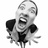

In [26]:
tf.keras.preprocessing.image.load_img('fer2013/train/Angry/1003.jpg')

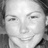

In [27]:
image = tf.keras.preprocessing.image.load_img('fer2013/train/Happy/1.jpg')
image

### Train and test set

In [28]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('fer2013/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.


In [29]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6])

In [30]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171], dtype=int64))

In [31]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

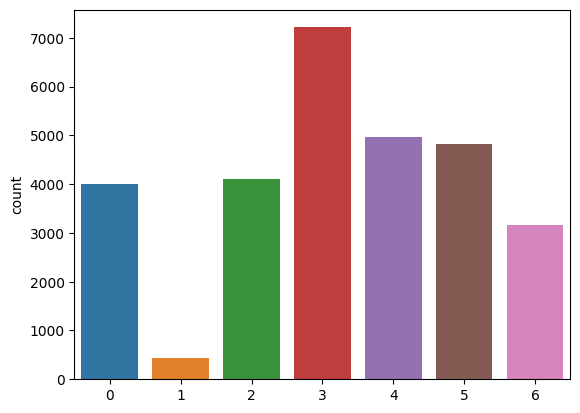

In [32]:
sns.countplot(x = train_dataset.classes);

In [33]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

In [34]:
2*2*2*32

256

In [35]:
num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 5

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [36]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# network.fit(train_dataset, epochs=epochs)

## Saving and loading the model

In [37]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [38]:
from keras.models import save_model
#network_saved = save_model(network, 'weights_emotions.hdf5')

In [39]:
with open('network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()


In [40]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [41]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

## Model evaluation

In [42]:
network_loaded.evaluate(test_dataset)

3589/3589 [==============================] - 16s 4ms/step - loss: 1.4102 - accuracy: 0.5015


[1.4101645946502686, 0.5015324354171753]

In [43]:
predictions = network_loaded.predict(test_dataset)
predictions

3589/3589 [==============================] - 15s 4ms/step


array([[1.6947749e-01, 1.8220820e-02, 2.6272973e-01, ..., 2.0203973e-01,
        3.1791982e-01, 2.7976049e-02],
       [5.1471901e-01, 5.7262398e-02, 2.8832066e-01, ..., 1.7285695e-02,
        4.4682343e-02, 3.0486684e-02],
       [7.0077717e-01, 7.9992101e-02, 7.0902973e-02, ..., 6.1903257e-02,
        6.5601885e-02, 2.3266627e-03],
       ...,
       [9.9013355e-03, 6.1760918e-04, 8.9821957e-02, ..., 5.2017332e-03,
        3.0390483e-03, 8.8886291e-01],
       [4.2150352e-02, 1.2623385e-03, 1.3670957e-01, ..., 1.9171692e-01,
        3.2179777e-02, 5.8674419e-01],
       [3.0459104e-02, 9.5052790e-04, 7.7095240e-02, ..., 2.6253372e-02,
        1.7160838e-02, 8.0128974e-01]], dtype=float32)

In [44]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([5, 0, 0, ..., 6, 6, 6], dtype=int64)

In [45]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6])

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.5015324602953469

In [47]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[161,   6,  39,  43, 108, 103,  31],
       [ 15,   7,   9,   3,   5,  13,   3],
       [ 38,   5,  90,  56,  80, 134, 125],
       [  3,   1,  12, 771,  29,  35,  28],
       [ 58,   1,  43, 172, 141, 122,  89],
       [ 17,   0,  38,  71, 145, 306,  17],
       [  4,   0,  22,  34,  21,  11, 324]], dtype=int64)

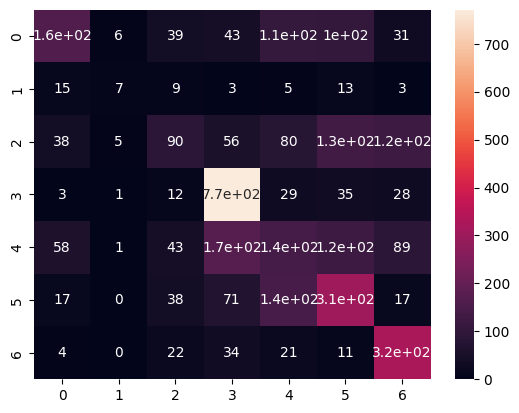

In [49]:
sns.heatmap(cm, annot=True);

In [50]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.54      0.33      0.41       491
           1       0.35      0.13      0.19        55
           2       0.36      0.17      0.23       528
           3       0.67      0.88      0.76       879
           4       0.27      0.23      0.24       626
           5       0.42      0.52      0.46       594
           6       0.53      0.78      0.63       416

    accuracy                           0.50      3589
   macro avg       0.45      0.43      0.42      3589
weighted avg       0.47      0.50      0.47      3589



## Classifying one single image

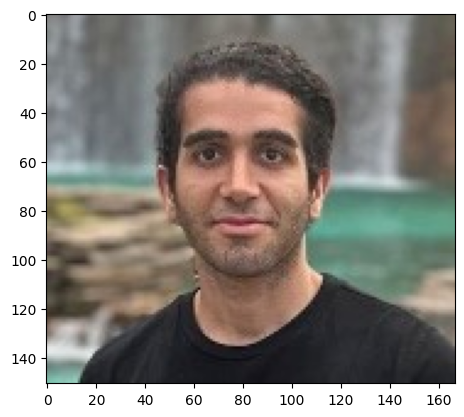

In [51]:
import matplotlib.pyplot as plt
from IPython.display import display, Image

image = cv2.imread('image1.jpg')

#Image(filename='image1.jpg')
#display(Image(data=cv2.imencode('.jpg', image)[1].tobytes()))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [52]:
image.shape

(151, 167, 3)

In [53]:
face_detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

In [54]:
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)

In [55]:
faces

array([[ 40,  27,  78,  78],
       [104,  56,  56,  56]])

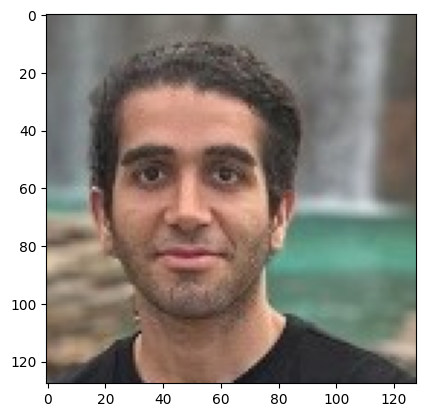

In [56]:
roi_ = image[2:2 + 128, 30:30 + 128]

plt.imshow(cv2.cvtColor(roi_, cv2.COLOR_BGR2RGB))

In [57]:
roi_.shape

(128, 128, 3)

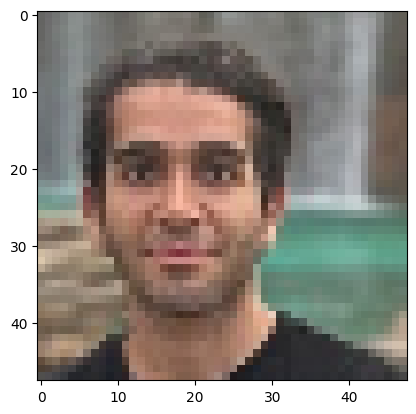

In [58]:
roi = cv2.resize(roi_, (48, 48))
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

In [59]:
roi.shape

(48, 48, 3)

In [60]:
roi

array([[[ 99, 101, 101],
        [107, 106, 107],
        [115, 116, 114],
        ...,
        [101, 106, 105],
        [ 90,  96,  97],
        [ 86,  95,  98]],

       [[ 98, 100, 100],
        [109, 108, 109],
        [117, 118, 116],
        ...,
        [100, 105, 104],
        [ 90,  96,  98],
        [ 86,  94,  97]],

       [[ 99, 101, 101],
        [110, 110, 110],
        [121, 122, 120],
        ...,
        [ 97, 103, 102],
        [ 87,  95,  96],
        [ 88,  94,  99]],

       ...,

       [[ 61,  78,  99],
        [ 78,  98, 116],
        [ 89, 107, 125],
        ...,
        [ 98, 107, 110],
        [108, 118, 126],
        [106, 116, 126]],

       [[ 52,  64,  77],
        [ 59,  67,  79],
        [ 71,  76,  84],
        ...,
        [ 56,  58,  59],
        [ 72,  79,  79],
        [ 95, 101, 102]],

       [[ 77,  79,  80],
        [ 79,  76,  78],
        [ 71,  67,  67],
        ...,
        [ 51,  49,  49],
        [ 60,  60,  60],
        [ 71,  71,  71]]

In [61]:
roi = roi / 255
roi

array([[[0.38823529, 0.39607843, 0.39607843],
        [0.41960784, 0.41568627, 0.41960784],
        [0.45098039, 0.45490196, 0.44705882],
        ...,
        [0.39607843, 0.41568627, 0.41176471],
        [0.35294118, 0.37647059, 0.38039216],
        [0.3372549 , 0.37254902, 0.38431373]],

       [[0.38431373, 0.39215686, 0.39215686],
        [0.42745098, 0.42352941, 0.42745098],
        [0.45882353, 0.4627451 , 0.45490196],
        ...,
        [0.39215686, 0.41176471, 0.40784314],
        [0.35294118, 0.37647059, 0.38431373],
        [0.3372549 , 0.36862745, 0.38039216]],

       [[0.38823529, 0.39607843, 0.39607843],
        [0.43137255, 0.43137255, 0.43137255],
        [0.4745098 , 0.47843137, 0.47058824],
        ...,
        [0.38039216, 0.40392157, 0.4       ],
        [0.34117647, 0.37254902, 0.37647059],
        [0.34509804, 0.36862745, 0.38823529]],

       ...,

       [[0.23921569, 0.30588235, 0.38823529],
        [0.30588235, 0.38431373, 0.45490196],
        [0.34901961, 0

In [62]:
roi.shape

(48, 48, 3)

In [63]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [64]:
probs = network_loaded.predict(roi)
probs

1/1 [==============================] - 0s 185ms/step


array([[0.1786621 , 0.00184661, 0.10650797, 0.0217574 , 0.43449873,
        0.22652128, 0.03020595]], dtype=float32)

In [65]:
result = np.argmax(probs)
result

4

In [66]:
categories = test_dataset.class_indices
categories

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [67]:
#display(Image(data=cv2.imencode('.jpg', roi_)[1].tobytes()))
for key, val in categories.items():
    if val == result:
        detected_emotion = key
print('Prediction: ', detected_emotion)

Prediction:  Neutral


## Classifying multiple images

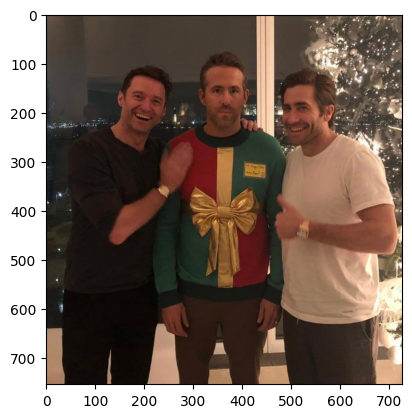

In [68]:
image = cv2.imread('image2.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [69]:
faces = face_detector.detectMultiScale(image)
faces

array([[315, 117, 103, 103],
       [153, 132, 104, 104],
       [386, 358,  45,  45],
       [453, 150, 106, 106]])

In [70]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [71]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 [==============================] - 0s 21ms/step


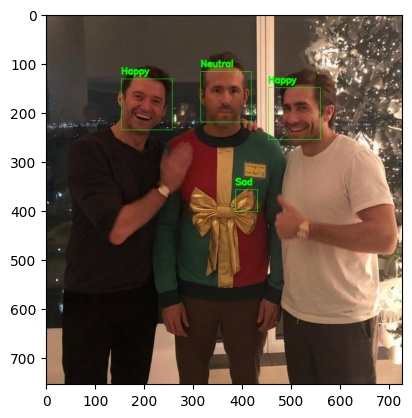

In [72]:
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi = image[y:y + h, x:x + w]
  #cv2_imshow(roi)
  roi = cv2.resize(roi, (48, 48))
  #cv2_imshow(roi)
  roi = roi / 255
  roi = np.expand_dims(roi, axis = 0)
  #print(roi.shape)
  prediction = network_loaded.predict(roi)
  #print(prediction)
  cv2.putText(image, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


## Webcam

In [74]:
import cv2
import numpy as np
from time import sleep
from tensorflow.keras.utils import img_to_array


face_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)
        roi_gray = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)

    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = network_loaded.predict(roi)[0]
        label = emotions[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()   